In [14]:
import pandas as pd
import numpy as np
import re
import math
import sklearn

from dowhy import CausalModel
from dowhy import gcm

import graphviz
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# What is the effect of offering extra study time to all students on their G3?

In [16]:
por_raw_df = pd.read_csv('data/student-por_raw.csv')
por_df = por_raw_df.copy()

In [17]:
causal_graph = nx.DiGraph()

positions = {
    "G3": (-2.378, 2.611),
    "paid classes": (-3.205, 0.343),
    "Famrel": (-2.138, -5.079),
    "Fedu": (-0.724, -5.114),
    "Fjob": (-4.009, -2.641),
    "Medu": (0.242, -5.045),
    "Mjob": (-2.958, -2.692),
    "absences": (1.424, 2.663),
    "address": (2.482, 6.977),
    "failures": (2.436, -2.351),
    "famsup": (-1.553, -2.674),
    "freetime": (2.444, 1.981),
    "goout": (2.428, 0.207),
    "health": (3.696, 4.402),
    "higher": (1.185, -2.433),
    "school": (0.782, 6.977),
    "schoolsup": (0.784, 4.377),
    "studytime": (-0.547, 0.036),
    "traveltime": (2.459, 5.084),
}

for node, pos in positions.items():
    causal_graph.add_node(node, pos=pos)

# Add edges
edges = [
    ("paid classes", "G3"),
    ("paid classes", "studytime"),
    ("Famrel", "famsup"),
    ("Fedu", "Fjob"),
    ("Fedu", "famsup"),
    ("Fedu", "higher"),
    ("Fjob", "paid classes"),
    ("Medu", "Mjob"),
    ("Medu", "famsup"),
    ("Medu", "higher"),
    ("Mjob", "paid classes"),
    ("absences", "G3"),
    ("absences", "failures"),
    ("address", "school"),
    ("address", "traveltime"),
    ("failures", "higher"),
    ("famsup", "paid classes"),
    ("famsup", "higher"),
    ("famsup", "studytime"),
    ("freetime", "goout"),
    ("freetime", "studytime"),
    ("goout", "studytime"),
    ("health", "absences"),
    ("health", "goout"),
    ("health", "schoolsup"),
    ("higher", "studytime"),
    ("school", "schoolsup"),
    ("school", "traveltime"),
    ("schoolsup", "studytime"),
    ("studytime", "G3"),
    ("traveltime", "freetime"),
]

causal_graph.add_edges_from(edges)

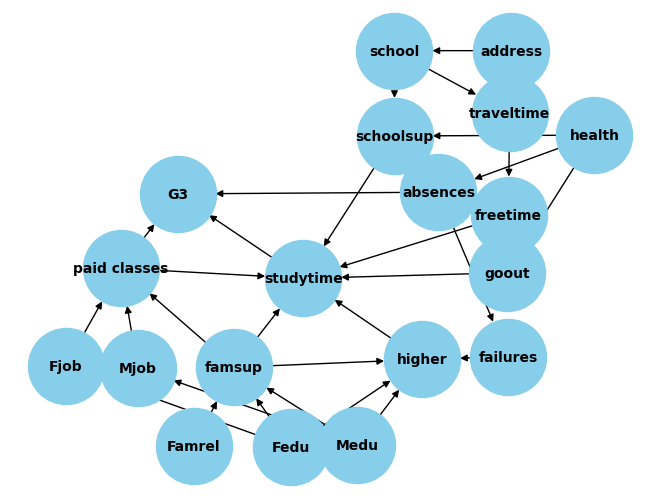

In [18]:
pos = nx.get_node_attributes(causal_graph, 'pos')
nx.draw(causal_graph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold")
plt.show()

In [19]:
df_model = pd.DataFrame(columns=['school', 'address', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G3'])

In [20]:
df_model.head()

,school,address,Medu,Fedu,Mjob,Fjob,traveltime,studytime,failures,schoolsup,famsup,paid,higher,famrel,freetime,goout,health,absences,G3


c:\Users\adams\miniconda3\envs\causal_test\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


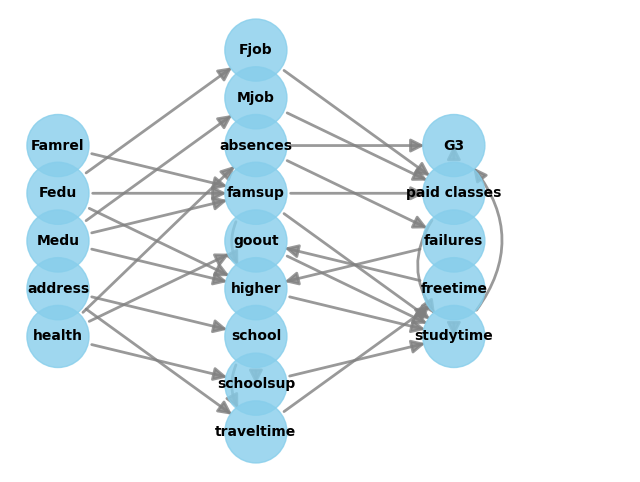

In [21]:
model = CausalModel(data=df_model, graph=causal_graph, treatment='schoolsup', outcome='G3')
model.view_model()

In [22]:
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                             
────────────(E[G3|health,freetime])
d[schoolsup]                       
Estimand assumption 1, Unconfoundedness: If U→{schoolsup} and U→G3 then P(G3|schoolsup,health,freetime,U) = P(G3|schoolsup,health,freetime)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [23]:
por_filtered_df = por_df.drop(columns=['sex', 'reason', 'famsize', 'internet', 'guardian', 'nursery', 'activities', 'romantic', 'Pstatus', 'age', 'Walc', 'Dalc', 'G1', 'G2'])

In [ ]:
df_encoded = pd.get_dummies(df_model, columns=[categorical_columns], drop_first=True) 

In [27]:
model = CausalModel(data=por_filtered_df, graph=causal_graph, treatment='health', outcome='G3')

c:\Users\adams\miniconda3\envs\causal_test\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [28]:
estimands = model.identify_effect(proceed_when_unidentifiable=True)
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d           
─────────(E[G₃])
d[health]       
Estimand assumption 1, Unconfoundedness: If U→{health} and U→G3 then P(G3|health,,U) = P(G3|health,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [29]:
estimate = model.estimate_effect(estimands,
                                 method_name="backdoor.linear_regression",
                                 effect_modifiers=[],
                                 confidence_intervals=True,
                                 test_significance=True)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d           
─────────(E[G₃])
d[health]       
Estimand assumption 1, Unconfoundedness: If U→{health} and U→G3 then P(G3|health,,U) = P(G3|health,)

## Realized estimand
b: G3~health
Target units: ate

## Estimate
Mean value: -0.22081409281376452
p-value: [0.01174877]
95.0% confidence interval: [[-0.39241575 -0.04921243]]



c:\Users\adams\miniconda3\envs\causal_test\lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [30]:
estimate.interpret()

Increasing the treatment variable(s) [health] from 0 to 1 causes an increase of -0.22081409281376452 in the expected value of the outcome [['G3']], over the data distribution/population represented by the dataset.
